In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, constraintASparse, plotSwitches, removeRedundantSwitches,\
                    consumption, setupAxis

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

%load_ext autoreload
%autoreload 2


# Switching time optimization modules
import switching_times_1st as st1
import switching_times_1st_rk as st1_rk
import switching_times_2nd as st2

from model_loader import *
from color_loader import *

import lxml

import seaborn as sns
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

sns.set(style='ticks', palette='Set2')

# Data

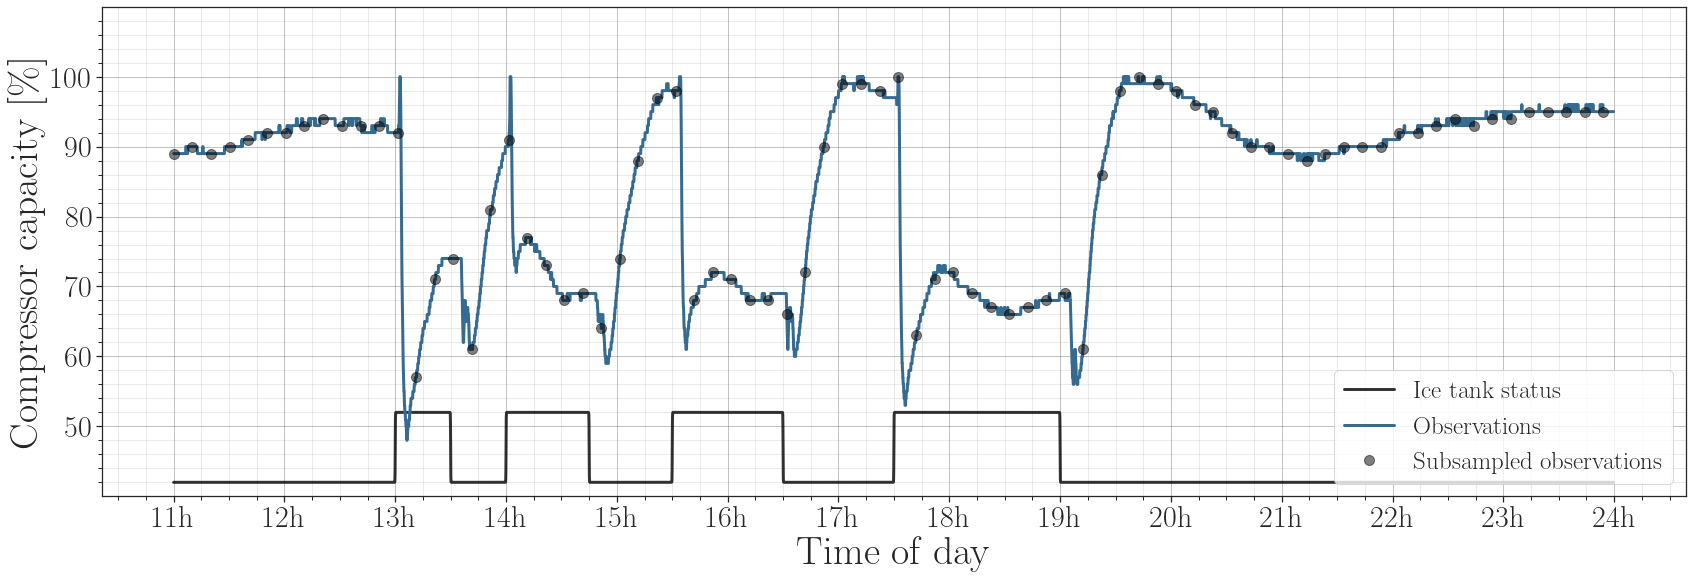

In [2]:
data_full = pd.read_csv('../../data/high_tc_20190913.csv', sep = ';', encoding="latin1", header = 0, index_col = 0)


data_full.index = pd.to_datetime(data_full.index, format='%Y-%m-%d %H:%M:%S')
data = data_full.filter(['A40_A_CompCap'], axis=1)
data['A40_A_CompCap'] = data['A40_A_CompCap']/100
data['t'] = 60 * data_full.index.hour + data_full.index.minute + 1/60 * data_full.index.second
data['t'] = data['t'] - data['t'][0]

tf = data['t'][-1]

k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.

switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))

fig = plt.figure(figsize=(25,8))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(t_all,smooth_regime(t_all,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=3,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'], '-',linewidth=3,color=blue[1],alpha = 1,label=r'$\textnormal{Observations}$')
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')

#ax.plot(T_stoch, Y_stoch[0])



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')
plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)

fig.savefig(FIGS + '/modelling/fridge_data.pdf',format='pdf')



## First order model

In [3]:
lambda_MELT = 0.137293
lambda_IDLE = 0.042161
mu_MELT = 68.6768
mu_IDLE = 94.9104
logsigma = -3.752410
logR = -12.411654
pars = np.array([lambda_MELT, mu_MELT, lambda_IDLE, mu_IDLE, np.exp(logsigma), np.exp(logR)])
m1_manual = firstordermodel(pars)

tf = 60 * 24
x0_1_manual = np.array(88.9965)

### With test switches from data

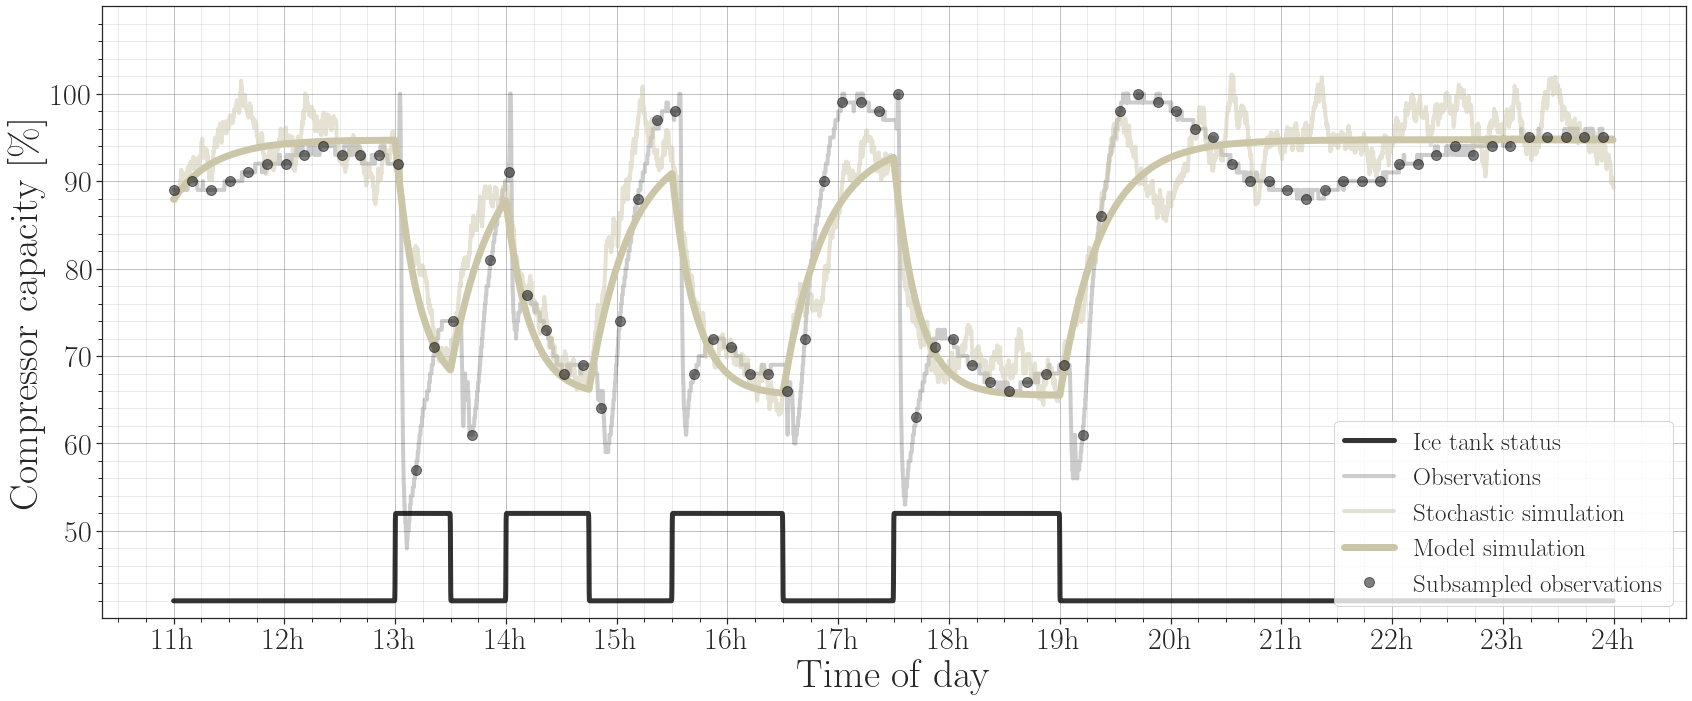

In [4]:
tf = data['t'][-1]
t0 = data['t'][0]

x0 = x0_1
np.random.seed(1234)
T, X, Z = sol_ivp_wrapper_discrete(m1,x0,switches_data,t0,tf,data['t'])
T_stoch, X_stoch, Y_stoch, Z_stoch = stochasticSimulation(m1,switches_data,x0,0,13*60,0.1)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'], '-',linewidth=4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(T_stoch, Z_stoch[0],linewidth=4,alpha =0.5,color=col_mod1_line,label=r'$\textnormal{Stochastic simulation}$')
ax.plot(T, Z[0],linewidth=7,color=col_mod1_line,label=r'$\textnormal{Model simulation}$') #dodgerblue
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')

#ax.plot(T_stoch, Y_stoch[0])



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')
plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)

fig.savefig(FIGS + '/modelling/1st_order_fit.pdf',format='pdf')


# Residuals

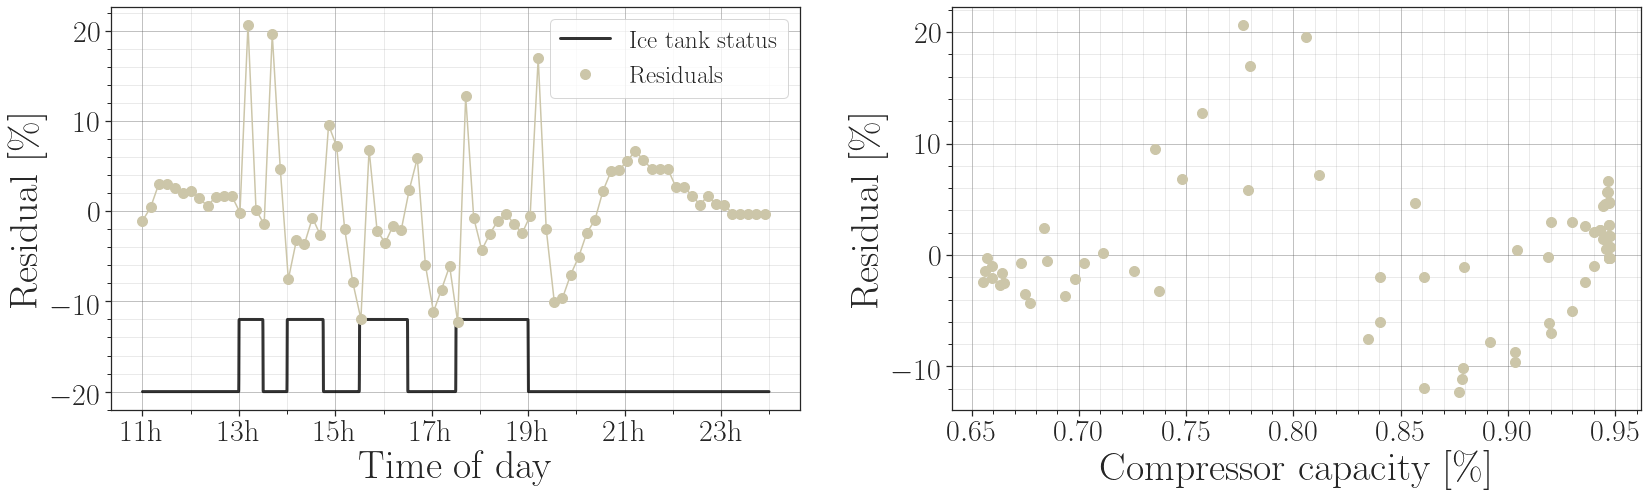

In [5]:
T, X, Z = sol_ivp_wrapper_discrete(m1,x0,switches_data,t0,tf,t)

res = Z[0] - data['A40_A_CompCap'][::100]
fig = plt.figure(figsize=(25,7))    
ax = fig.add_subplot(121)
ax.plot(t_all,100*(smooth_regime(t_all,switches_data)*0.08-0.2),alpha=0.8,color='black',linewidth=3,label=r'$\textnormal{Ice tank status}$')
ax.plot(T,100*res,'-',color=col_mod1_line)
ax.plot(T,100*res,'.',color=col_mod1_line,markersize=20,label=r'$\textnormal{Residuals}$')
setupAxis(ax)
ax.set_xticks(np.arange(0,14,2)*(60.) )
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,2) * 60.])
ax.xaxis.set_minor_locator(MultipleLocator(60))
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Residual  [\%]}$',size = 40)
ax.legend(prop={'size': 25},ncol=1,loc = 'upper right')

ax2 = fig.add_subplot(122)
ax2.plot(Z[0],100*res,'.',color=col_mod1_line,markersize=20)
setupAxis(ax2,nolegend=True)
ax2.set_xlabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax2.set_ylabel(r'$\textnormal{Residual  [\%]}$',size = 40)


plt.subplots_adjust(hspace = 0.,bottom=0.15, top =0.95,left = 0.1, right = 0.95,wspace=0.22)


fig.savefig(FIGS + '/modelling/1st_order_res.pdf',format='pdf')


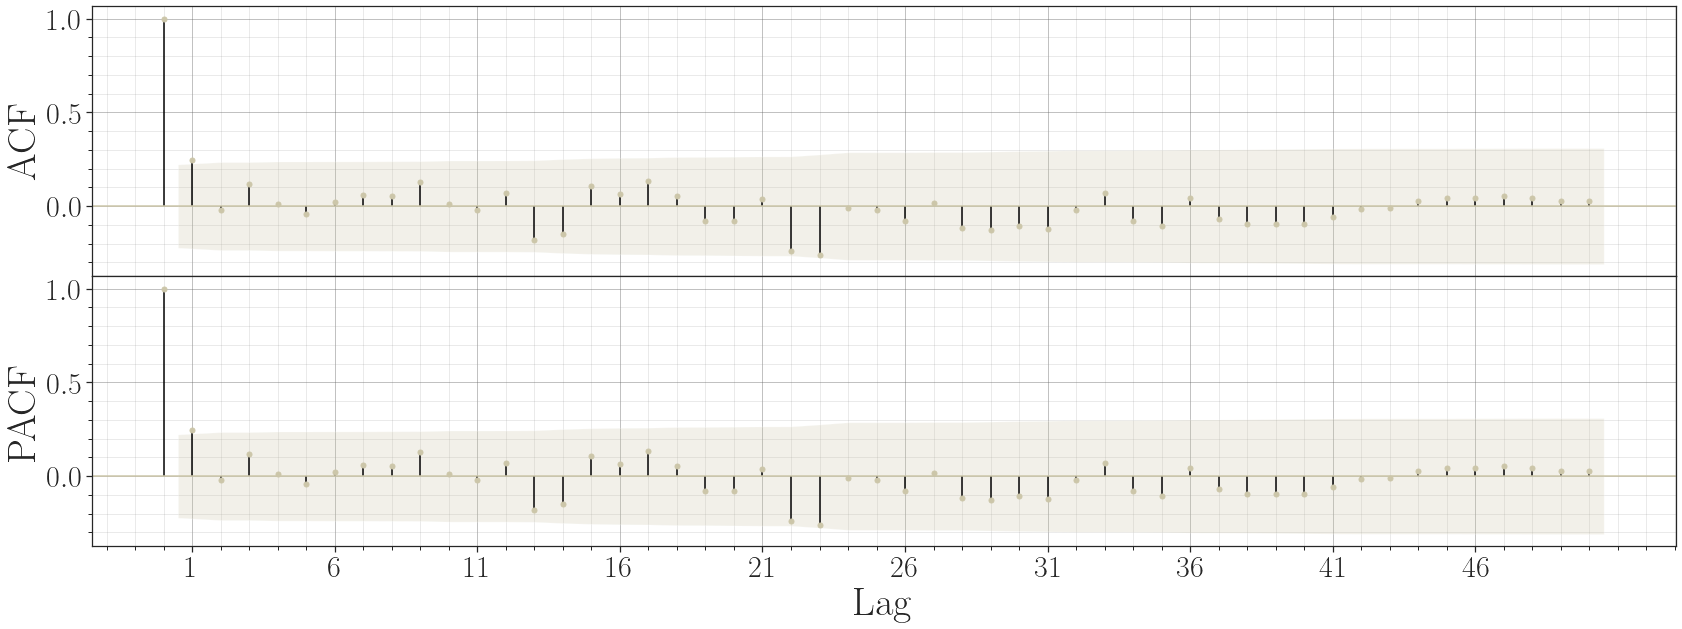

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

colors_models_first = [col_mod1_line, "#C4961A", "#F4EDCA", "#D16103", "#C3D7A4", "#52854C", "#4E84C4", "#293352"]
sns.set(style='ticks', palette=colors_models_first)

fig = plt.figure(figsize=(25,10))    
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_acf(res,ax=ax1,lags=50,color=col_mod1_line)
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(1,50,5) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{ACF}$',size = 40)
ax1.set_title('')

plot_acf(res,ax=ax2,lags=50,color=col_mod1_line)
setupAxis(ax2,nolegend=True)
ax2.set_xticks(np.arange(1,50,5) )
ax2.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax2.set_ylabel(r'$\textnormal{PACF}$',size = 40)
ax2.set_title('')

plt.subplots_adjust(hspace = 0.4)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/1st_order_auto.pdf',format='pdf')




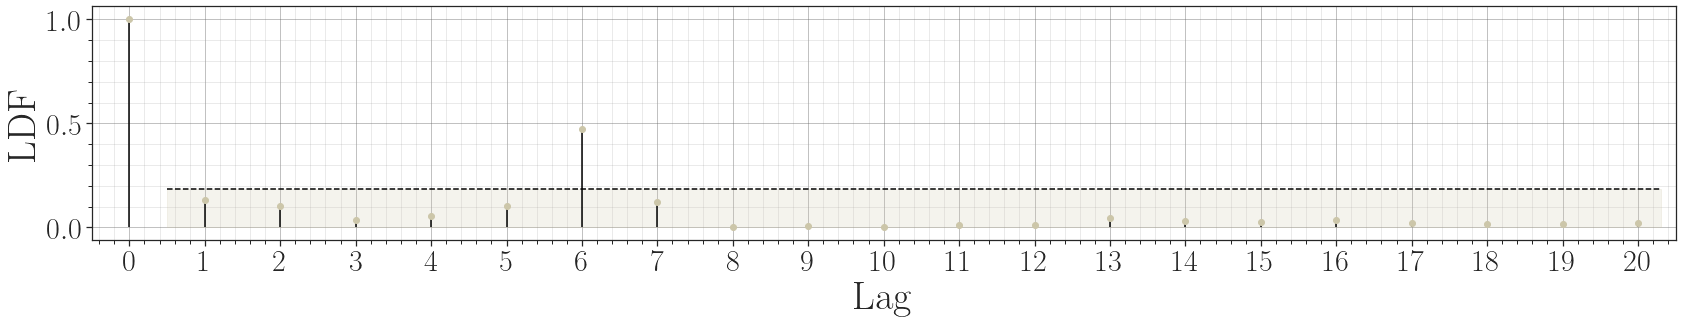

In [7]:
ldf = np.array([1,0.133230746, 0.104631164, 0.035040995, 0.053422061, 0.104395201, 0.474509191, 0.121124077, 0.001175953, 0.007352416,
 0.003265160, 0.011770528, 0.010772607, 0.043504269, 0.033033583, 0.024867944, 0.035823942, 0.020569249 ,0.017803645,
 0.016171612, 0.019619378])
quantile = 0.1835009 
fig = plt.figure(figsize=(25,5))    
ax1 = fig.add_subplot(111)
ax1.vlines(np.arange(0,21),0,ldf,zorder=2)
ax1.scatter(np.arange(0,21),ldf,zorder=10)
ax1.hlines(quantile,0.5,20.3,linestyles = 'dashed')
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(0,21,1) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{LDF}$',size = 40)
ax1.fill_between(np.array([0.5,20.3]), 0,quantile, alpha=0.2,color = 'C0',zorder=1)
ax1.set_title('')
ax1.set_xlim(-0.5,20.5)



plt.subplots_adjust(hspace = 0.,bottom=0.3, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/1st_order_ldf.pdf',format='pdf')

sns.set(style='ticks', palette='Set2')


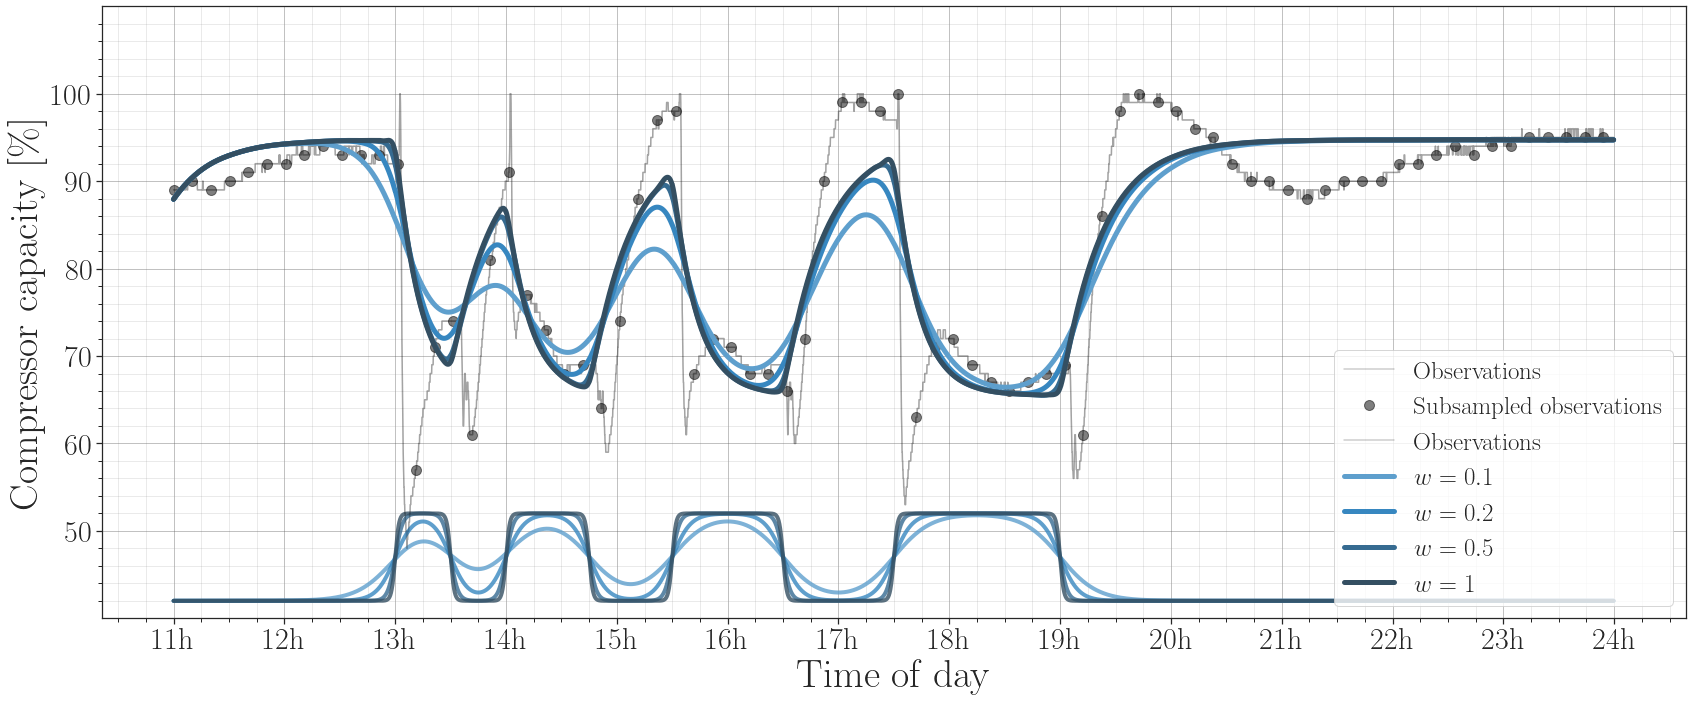

In [8]:
m1_01 = firstordermodel(m1.pars,regime_slope=0.1,smooth=True)
m1_02 = firstordermodel(m1.pars,regime_slope=0.2,smooth=True)
m1_05 = firstordermodel(m1.pars,regime_slope=0.5,smooth=True)
m1_1 = firstordermodel(m1.pars,regime_slope=1.,smooth=True)

t_all = data['t']
t = t_all[::100]

T, X, Z01 = sol_ivp_wrapper_discrete(m1_01,x0,switches_data,t0,tf,t_all)
T, X, Z02 = sol_ivp_wrapper_discrete(m1_02,x0,switches_data,t0,tf,t_all)
T, X, Z05 = sol_ivp_wrapper_discrete(m1_05,x0,switches_data,t0,tf,t_all)
T, X, Z1 = sol_ivp_wrapper_discrete(m1_1,x0,switches_data,t0,tf,t_all)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)

ax.plot(t_all, data['A40_A_CompCap'], '-',color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')
ax.plot(T,smooth_regime(T,switches_data,0.1)*0.1+0.42,alpha=0.8,color=blue[3],linewidth=4)
ax.plot(T,smooth_regime(T,switches_data,0.2)*0.1+0.42,alpha=0.8,color=blue[2],linewidth=4)
ax.plot(T,smooth_regime(T,switches_data,0.5)*0.1+0.42,alpha=0.8,color=blue[1],linewidth=4)
ax.plot(T,smooth_regime(T,switches_data,1)*0.1+0.42,alpha=0.8,color=blue[0],linewidth=4)

ax.plot(t_all, data['A40_A_CompCap'], '-',color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')

ax.plot(T, Z01[0],label=r'$w = 0.1$',color=blue[3],linewidth=5)
ax.plot(T, Z02[0],label=r'$w = 0.2$',color=blue[2],linewidth=5)
ax.plot(T, Z05[0],label=r'$w = 0.5$',color=blue[1],linewidth=5)
ax.plot(T, Z1[0],label=r'$w = 1$',color=blue[0],linewidth=5)

setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc='lower right')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/control/smooth_fits.pdf',format='pdf')


## Second order model

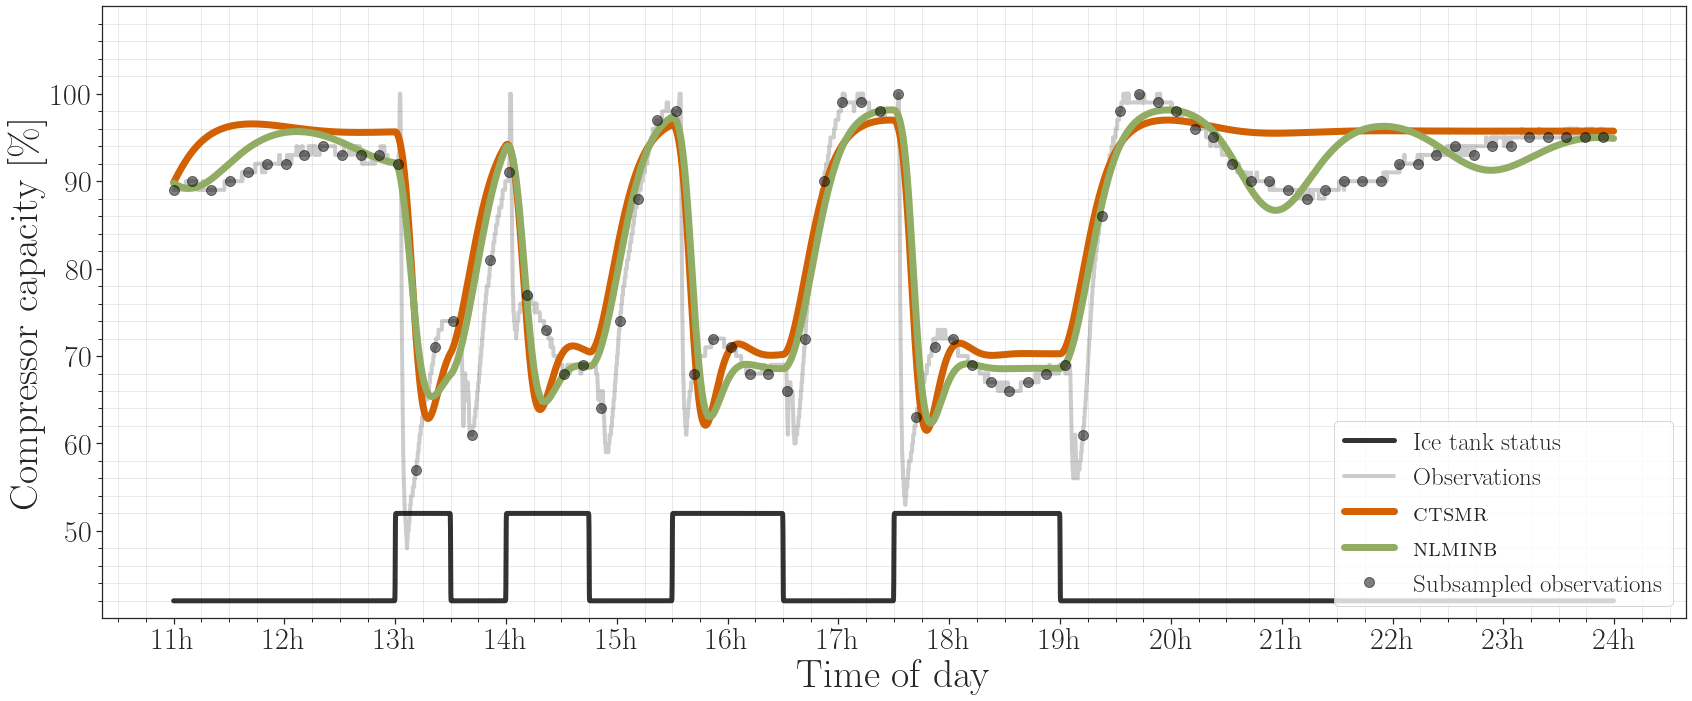

In [9]:
tf = data['t'][-1]
t0 = data['t'][0]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))
#x0 = x0_2_both
np.random.seed(1234)
T, X_nlminb, Z_nlminb = sol_ivp_wrapper_discrete(m2_both,x0_2_both,switches_data,t0,tf,data['t'])
T, X_ctsmr, Z_ctsmr = sol_ivp_wrapper_discrete(m2_both_ctsmr,x0_2_both_ctsmr,switches_data,t0,tf,data['t'])
#T_stoch, X_stoch, Y_stoch, Z_stoch = stochasticSimulation(m1,switches_data,x0,0,13*60,0.1)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'],'-',linewidth=4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(T, Z_ctsmr[0],linewidth=7,color=colors1[3],label=r'$\textnormal{\textsc{ctsmr}}$') #dodgerblue
ax.plot(T, Z_nlminb[0],linewidth=7,color=col_mod2_line,label=r'$\textnormal{\textsc{nlminb}}$') #dodgerblue
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')

#ax.plot(T_stoch, Y_stoch[0])



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')

ax.grid()
plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/2nd_order_two_unsclaed.pdf',format='pdf')


# Scaled model

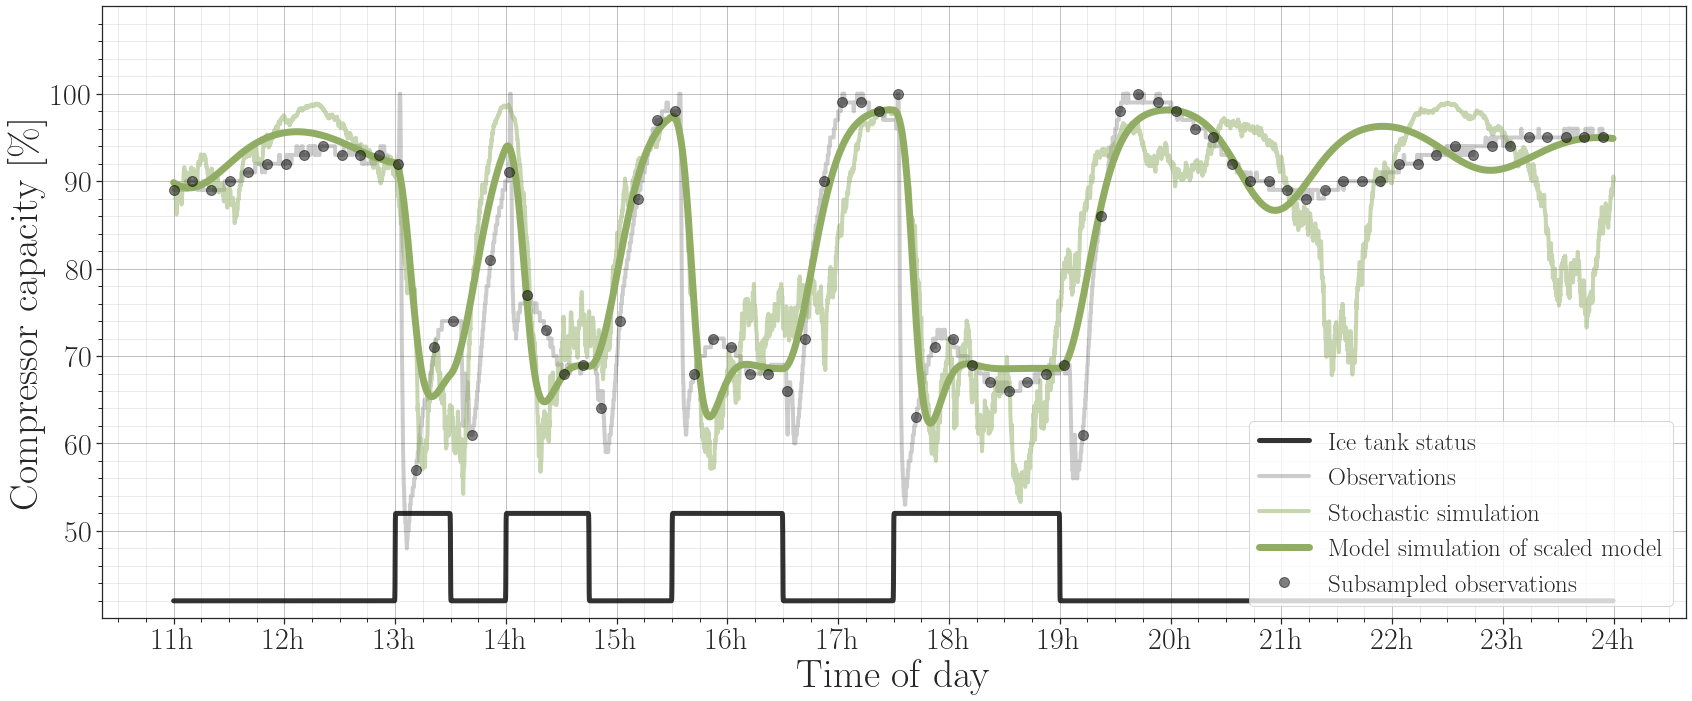

In [10]:
tf = data['t'][-1]
t0 = data['t'][0]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))
#x0 = x0_2_both
np.random.seed(1236)
T, X, Z = sol_ivp_wrapper_discrete(m2_both_scaled,x0_2_both_scaled,switches_data,t0,tf,data['t'])
T_stoch, X_stoch, Y_stoch, Z_stoch = stochasticSimulation(m2_both_scaled,switches_data,x0_2_both_scaled,0,13*60,0.1)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'], '-',linewidth=4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(T_stoch, Z_stoch[0],alpha =0.5,color=col_mod2_line,linewidth=4,label=r'$\textnormal{Stochastic simulation}$')
ax.plot(T, Z[0],linewidth=7,color=col_mod2_line,label=r'$\textnormal{Model simulation of scaled model}$') #dodgerblue
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/2nd_order_scaled.pdf',format='pdf')


# Residuals

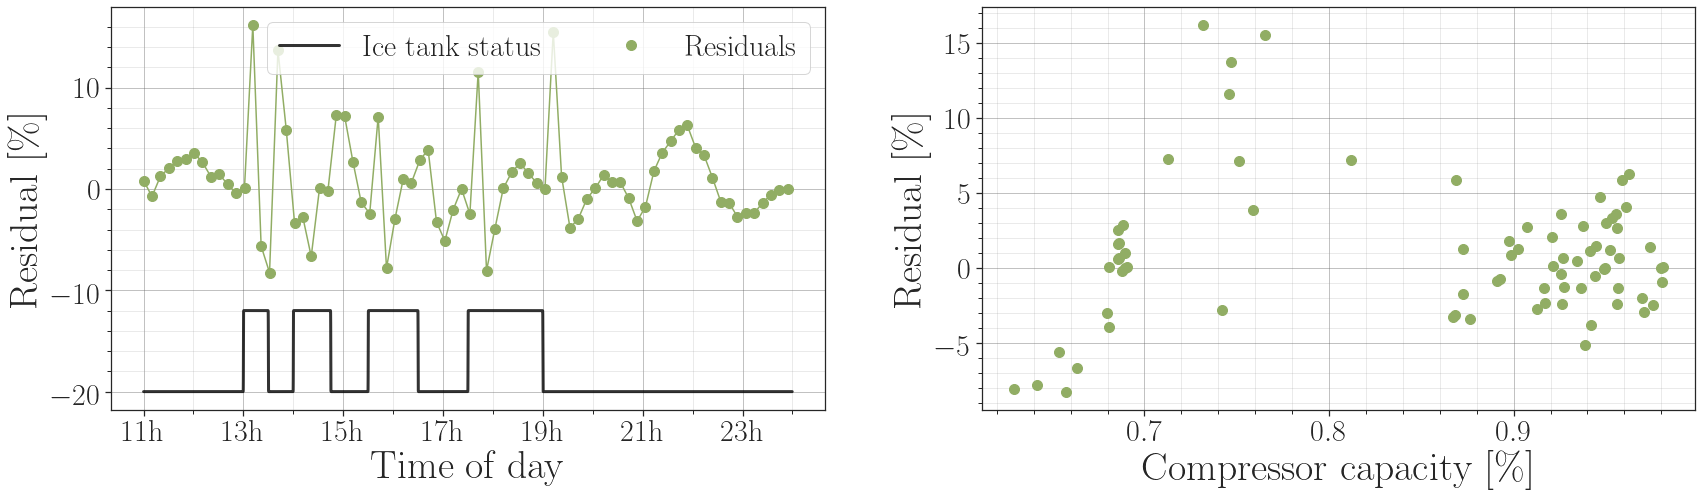

In [11]:
T, X, Z = sol_ivp_wrapper_discrete(m2_both_scaled,x0_2_both_scaled,switches_data,t0,tf,t)

res = Z[0] - data['A40_A_CompCap'][::100]
fig = plt.figure(figsize=(25,7))    
ax = fig.add_subplot(121)
ax.plot(t_all,100*(smooth_regime(t_all,switches_data)*0.08-0.2),alpha=0.8,color='black',linewidth=3,label=r'$\textnormal{Ice tank status}$')
ax.plot(T,100*res,'-',color=col_mod2_line)
ax.plot(T,100*res,'.',color=col_mod2_line,markersize=20,label=r'$\textnormal{Residuals}$')
setupAxis(ax)
ax.set_xticks(np.arange(0,14,2)*(60.) )
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,2) * 60.])
ax.xaxis.set_minor_locator(MultipleLocator(60))
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Residual [\%]}$',size = 40)
ax.legend(prop={'size': 30},ncol=2,loc = 'upper right')

ax2 = fig.add_subplot(122)
ax2.plot(Z[0],100*res,'.',color=col_mod2_line,markersize=20)
setupAxis(ax2,nolegend=True)
ax2.set_xlabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax2.set_ylabel(r'$\textnormal{Residual [\%]}$',size = 40)

#plt.subplots_adjust(wspace = 0.3)

plt.subplots_adjust(wspace = 0.22, hspace = 0.,bottom=0.15, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/2nd_order_res.pdf',format='pdf')


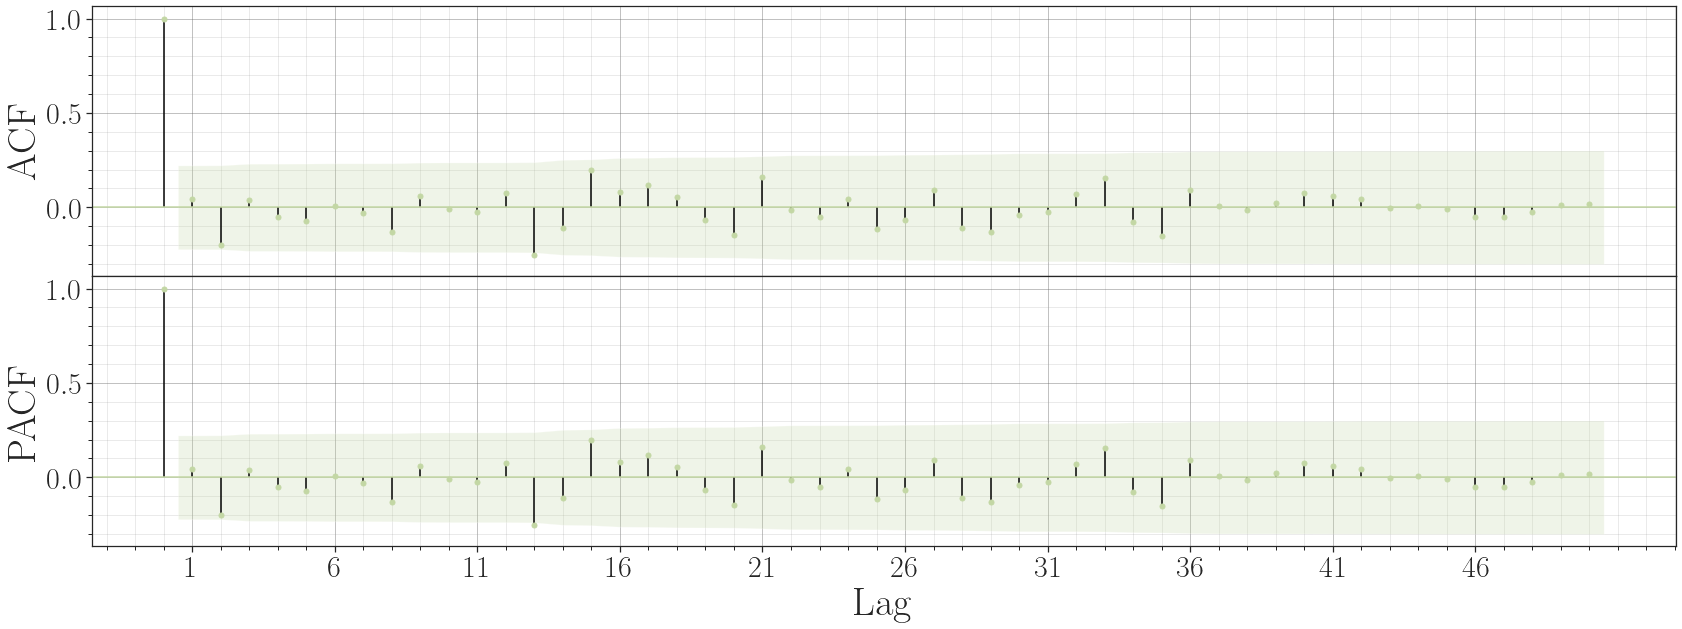

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

colors_models_first = [col_mod2, "#C4961A", "#F4EDCA", "#D16103", "#C3D7A4", "#52854C", "#4E84C4", "#293352"]
sns.set(style='ticks', palette=colors_models_first)

fig = plt.figure(figsize=(25,10))    
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_acf(res,ax=ax1,lags=50,color=col_mod2)
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(1,50,5) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{ACF}$',size = 40)
ax1.set_title('')

plot_acf(res,ax=ax2,lags=50,color=col_mod2)
setupAxis(ax2,nolegend=True)
ax2.set_xticks(np.arange(1,50,5) )
ax2.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax2.set_ylabel(r'$\textnormal{PACF}$',size = 40)
ax2.set_title('')
plt.subplots_adjust(hspace = 0.4)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/2nd_order_auto.pdf',format='pdf')



# Lag depency functions

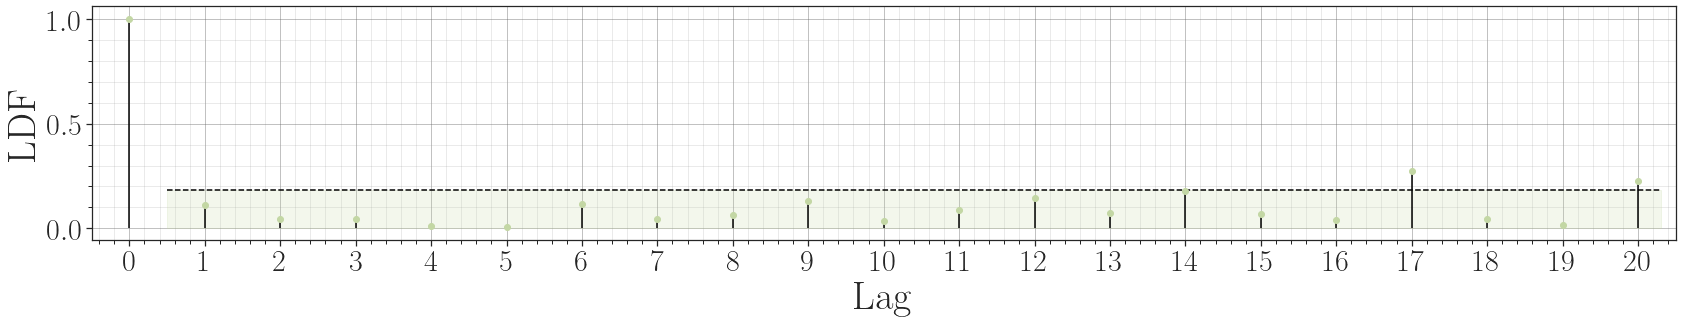

In [13]:
ldf = np.array([1,0.113024970, 0.044908919 ,0.045184855, 0.011676349, 0.005268548, 0.113801140, 0.041903306 ,0.064256029,
 0.128497106, 0.035021836, 0.086016108, 0.143832218, 0.074505607, 0.177511826, 0.069129536 ,0.039032339,
 0.272987743, 0.043573327, 0.016066324, 0.224347782])
quantile = 0.1835009 
#plt.plot(np.arange(0,21),ldf)
fig = plt.figure(figsize=(25,5))    
ax1 = fig.add_subplot(111)
ax1.vlines(np.arange(0,21),0,ldf,zorder=2)
ax1.scatter(np.arange(0,21),ldf,zorder=10)
ax1.hlines(quantile,0.5,20.3,linestyles = 'dashed')
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(0,21,1) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{LDF}$',size = 40)
ax1.fill_between(np.array([0.5,20.3]), 0,quantile, alpha=0.2,color = 'C0',zorder=1)
ax1.set_title('')
ax1.set_xlim(-0.5,20.5)

plt.subplots_adjust(bottom = 0.2)


plt.subplots_adjust(hspace = 0.,bottom=0.3, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/2nd_order_ldf.pdf',format='pdf')

sns.set(style='ticks', palette='Set2')


# Third order model

### Compare models

In [14]:
T, X_ctsmr, Z_ctsmr = sol_ivp_wrapper_discrete(m3_ctsmr,x0_3_ctsmr,switches_data,t0,tf,data['t'])
T, X_nlminb, Z_nlminb = sol_ivp_wrapper_discrete(m3_nlminb,x0_3_nlminb,switches_data,t0,tf,data['t'])

T_stoch, X_stoch_ctsmr, Y_stoch_ctsmr, Z_stoch_ctsmr = stochasticSimulation(m3_ctsmr,switches_data,x0_3_ctsmr,0,13*60,0.01)
T_stoch, X_stoch_nlminb, Y_stoch_nlminb, Z_stoch_nlminb = stochasticSimulation(m3_nlminb,switches_data,x0_3_nlminb,0,13*60,0.01)


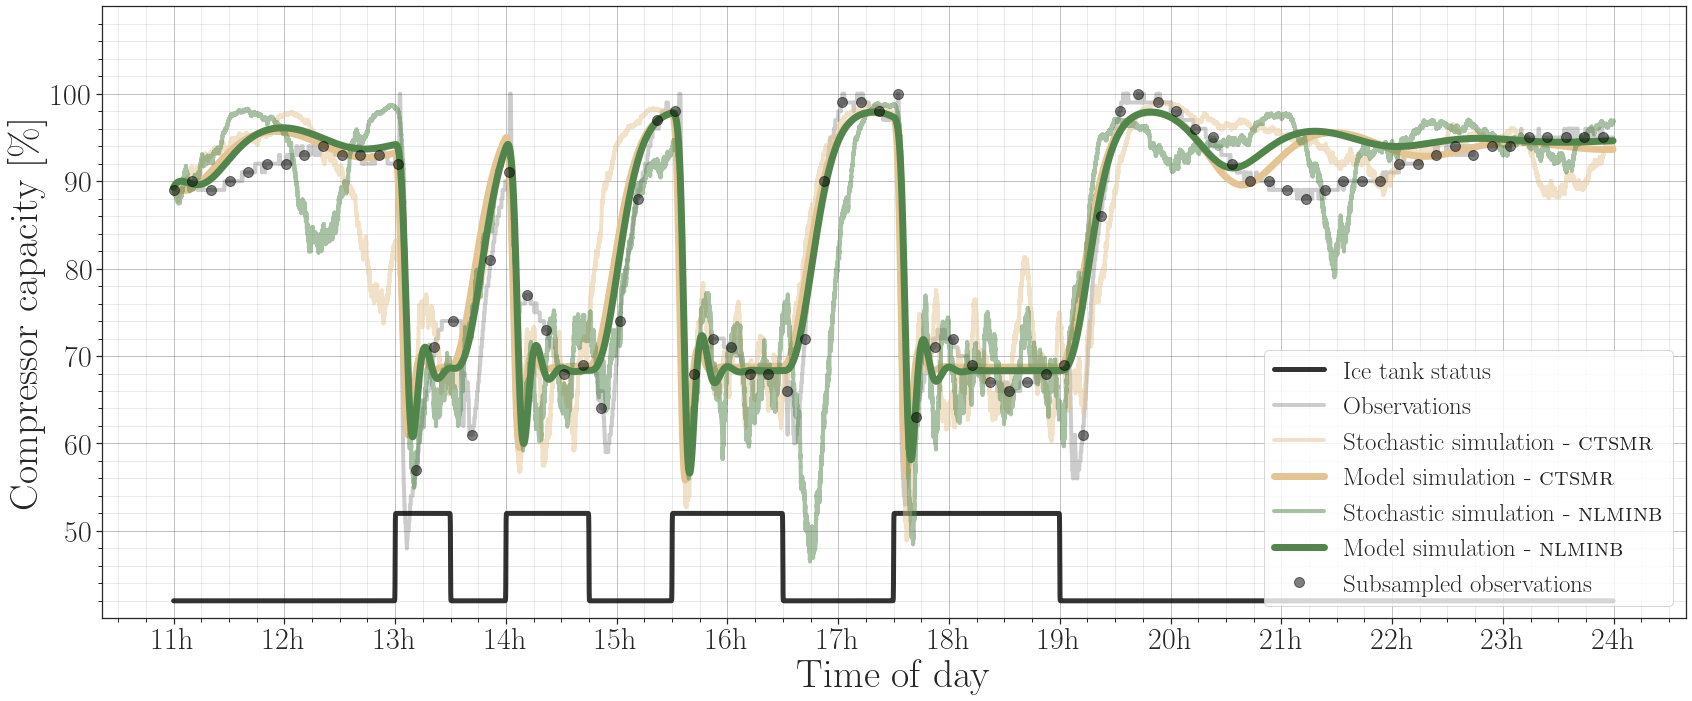

In [15]:
sns.set(style='ticks', palette='Set2')

tf = data['t'][-1]
t0 = data['t'][0]
switches_data = pd.to_datetime(["2019-09-17 13:00:00",
                 "2019-09-17 13:30:00",
                 "2019-09-17 14:00:00",
                 "2019-09-17 14:45:00",
                 "2019-09-17 15:30:00",
                 "2019-09-17 16:30:00",
                 "2019-09-17 17:30:00",
                 "2019-09-17 19:00:00"])
switches_data = (60 * (switches_data.hour - data_full.index.hour[0]) + switches_data.minute - data_full.index.minute[0]).astype(int)
tau_MELT_all_data, tau_IDLE_all_data  = derive_regimes(switches_data,tf,1)
switches_data = np.concatenate(derive_regimes(switches_data,0,0))


np.random.seed(1236)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'],'-',linewidth = 4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(T_stoch, Z_stoch_ctsmr[0],linewidth = 4,alpha =0.5,color='C6',label=r'$\textnormal{Stochastic simulation - \textsc{ctsmr}}$')
ax.plot(T, Z_ctsmr[0],linewidth=7,color='C6',label=r'$\textnormal{Model simulation - \textsc{ctsmr}}$') #dodgerblue
ax.plot(T_stoch, Z_stoch_nlminb[0],linewidth = 4,alpha =0.5,color=col_mod3,label=r'$\textnormal{Stochastic simulation - \textsc{nlminb}}$')
ax.plot(T, Z_nlminb[0],linewidth=7,color=col_mod3,label=r'$\textnormal{Model simulation - \textsc{nlminb}}$') #dodgerblue

ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')

plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/3rd_order_fits.pdf',format='pdf')


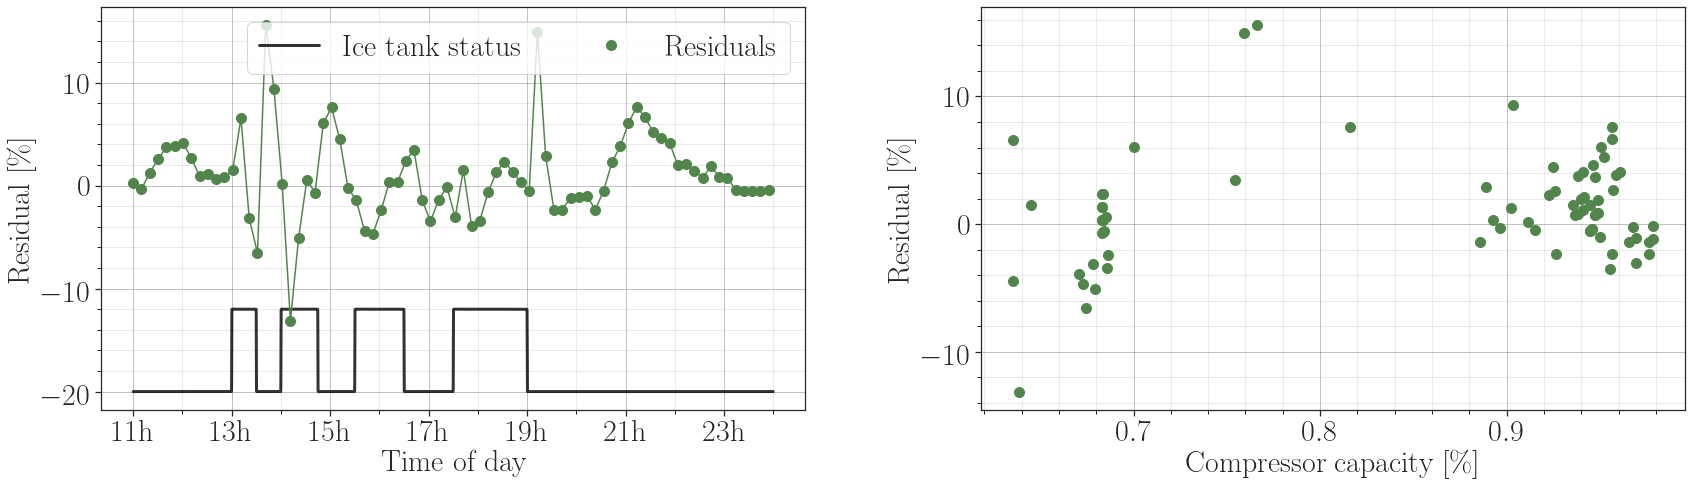

In [16]:
T, X, Z = sol_ivp_wrapper_discrete(m3_nlminb,x0_3_nlminb,switches_data,t0,tf,t)

res = Z[0] - data['A40_A_CompCap'][::100]
fig = plt.figure(figsize=(25,7))    
ax = fig.add_subplot(121)
ax.plot(t_all,100*(smooth_regime(t_all,switches_data)*0.08-0.2),alpha=0.8,color='black',linewidth=3,label=r'$\textnormal{Ice tank status}$')
ax.plot(T,100*res,'-',color=col_mod3)
ax.plot(T,100*res,'.',color=col_mod3,markersize=20,label=r'$\textnormal{Residuals}$')
setupAxis(ax)
ax.set_xticks(np.arange(0,14,2)*(60.) )
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,2) * 60.])
ax.xaxis.set_minor_locator(MultipleLocator(60))
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 30)
ax.set_ylabel(r'$\textnormal{Residual [\%]}$',size = 30)
ax.legend(prop={'size': 30},ncol=2,loc = 'upper right')

ax2 = fig.add_subplot(122)
ax2.plot(Z[0],100*res,'.',color=col_mod3,markersize=20)
setupAxis(ax2,nolegend=True)
ax2.set_xlabel(r'$\textnormal{Compressor capacity [\%]}$',size = 30)
ax2.set_ylabel(r'$\textnormal{Residual [\%]}$',size = 30)

plt.subplots_adjust(wspace = 0.25,hspace = 0.,bottom=0.15, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/3rd_order_res.pdf',format='pdf')


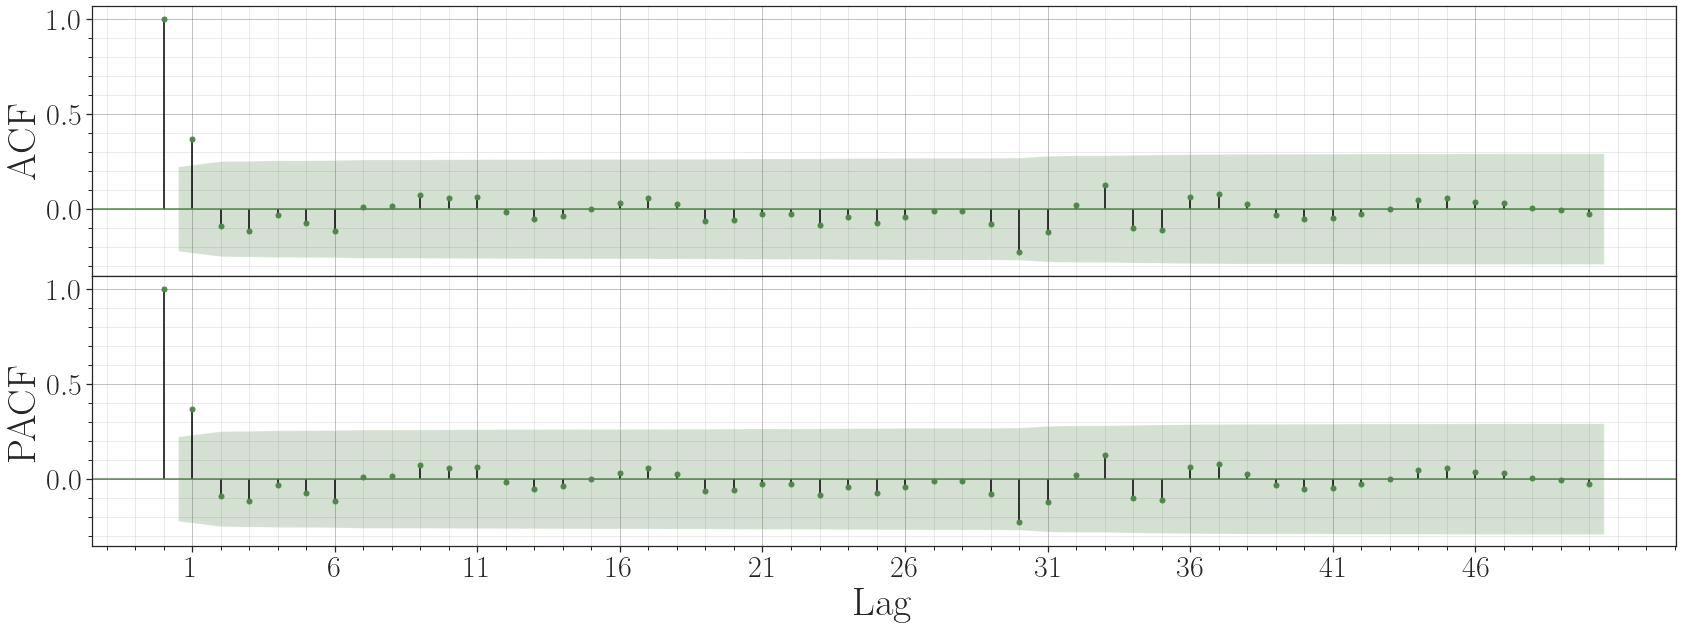

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

colors_models_first = [col_mod3, "#C4961A", "#F4EDCA", "#D16103", "#C3D7A4", "#52854C", "#4E84C4", "#293352"]
sns.set(style='ticks', palette=colors_models_first)

fig = plt.figure(figsize=(25,10))    
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_acf(res,ax=ax1,lags=50,color=col_mod3)
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(1,50,5) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{ACF}$',size = 40)
ax1.set_title('')

plot_acf(res,ax=ax2,lags=50,color=col_mod3)
setupAxis(ax2,nolegend=True)
ax2.set_xticks(np.arange(1,50,5) )
ax2.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax2.set_ylabel(r'$\textnormal{PACF}$',size = 40)
ax2.set_title('')
plt.subplots_adjust(hspace = 0.4)

plt.subplots_adjust(hspace = 0.,bottom=0.2, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/3rd_order_auto.pdf',format='pdf')



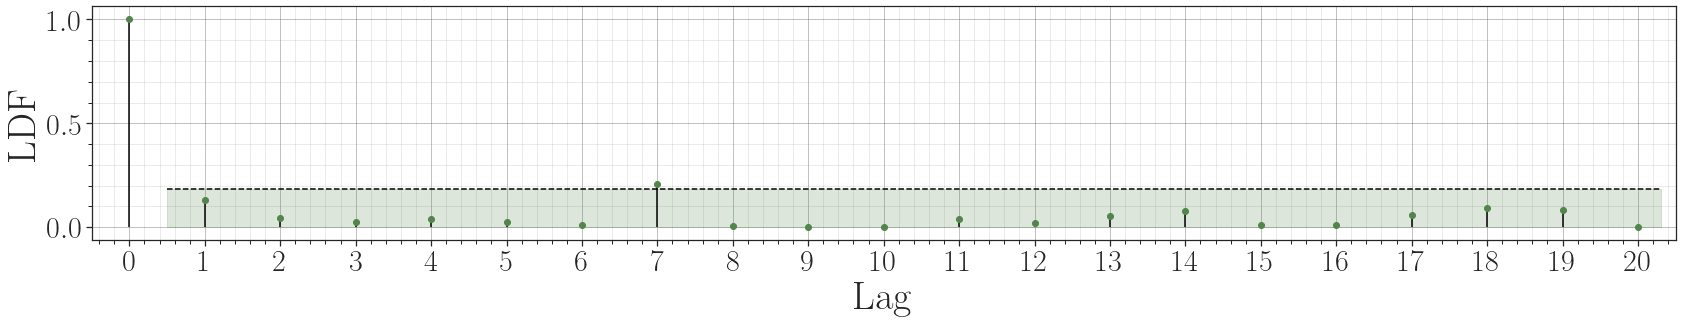

In [18]:
ldf = np.array([1,0.1296633088, 0.0456253558, 0.0231545103, 0.0405491198, 0.0269259963, 0.0123819027, 0.2087838168, 0.0070566017, 0.0032383314,
 0.0002979501, 0.0385961711, 0.0187447889, 0.0541113574, 0.0790146731, 0.0115468301, 0.0086938247, 0.0580927695, 0.0904769702,
0.0814348951, 0.0006298296])
quantile = 0.1835009 
#plt.plot(np.arange(0,21),ldf)
fig = plt.figure(figsize=(25,5))    
ax1 = fig.add_subplot(111)
ax1.vlines(np.arange(0,21),0,ldf,zorder=2)
ax1.scatter(np.arange(0,21),ldf,zorder=10)
ax1.hlines(quantile,0.5,20.3,linestyles = 'dashed')
setupAxis(ax1,nolegend=True)
ax1.set_xticks(np.arange(0,21,1) )
ax1.set_xlabel(r'$\textnormal{Lag}$',size = 40)
ax1.set_ylabel(r'$\textnormal{LDF}$',size = 40)
ax1.fill_between(np.array([0.5,20.3]), 0,quantile, alpha=0.2,color = 'C0',zorder=1)
ax1.set_title('')
ax1.set_xlim(-0.5,20.5)



plt.subplots_adjust(wspace = 0.25,hspace = 0.,bottom=0.3, top =0.95,left = 0.07, right = 0.95,)
fig.savefig(FIGS + '/modelling/3rd_order_ldf.pdf',format='pdf')

sns.set(style='ticks', palette='Set2')


# All three models

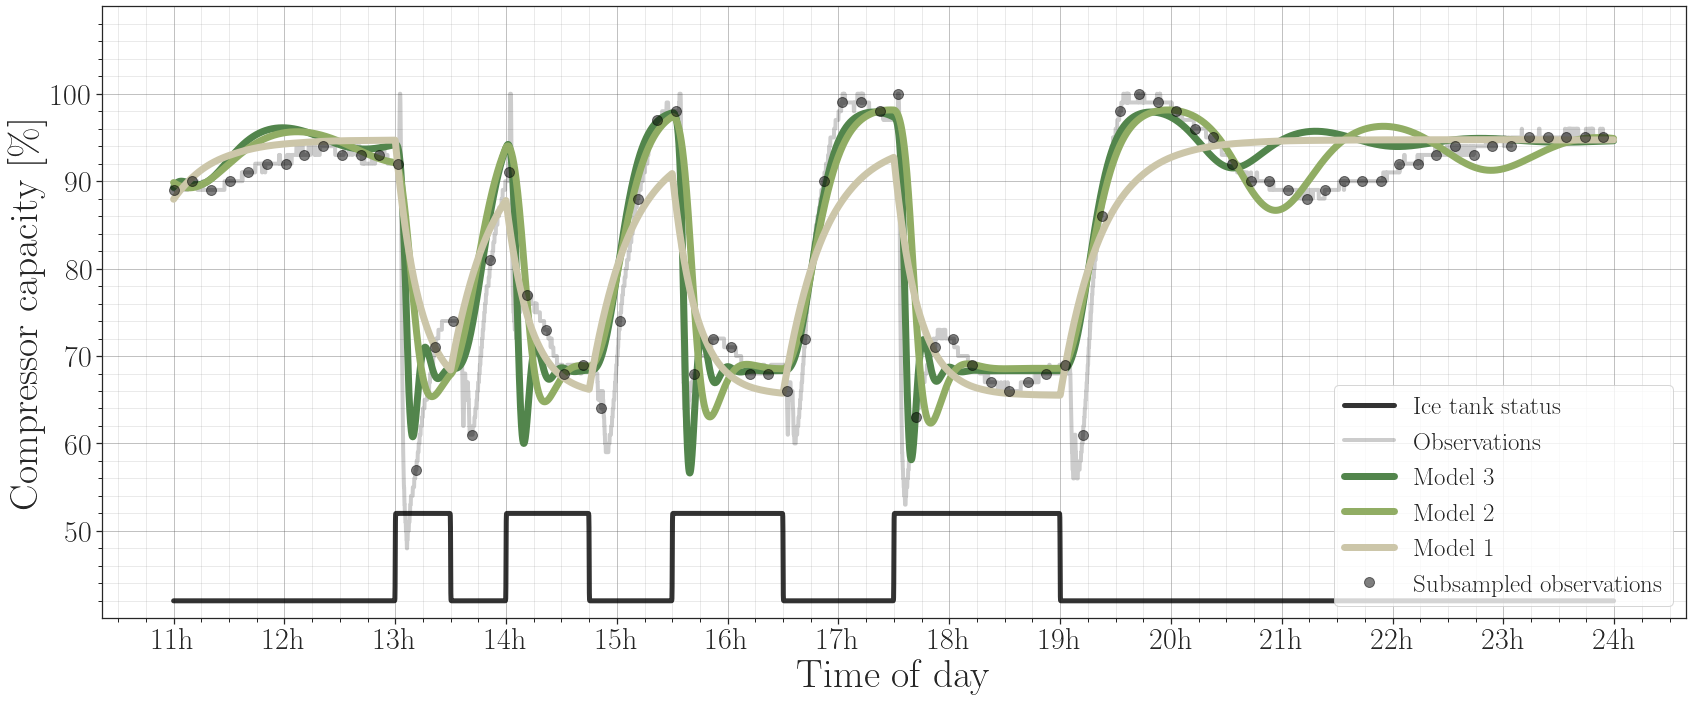

In [19]:
tf = data['t'][-1]
t0 = data['t'][0]

x0 = x0_1
np.random.seed(1234)
T, X, Z1 = sol_ivp_wrapper_discrete(m1,x0,switches_data,t0,tf,data['t'])
T, X, Z2 = sol_ivp_wrapper_discrete(m2_both_scaled,x0_2_both_scaled,switches_data,t0,tf,data['t'])
T, X, Z3 = sol_ivp_wrapper_discrete(m3_nlminb,x0_3_nlminb,switches_data,t0,tf,data['t'])
#T_stoch, X_stoch, Y_stoch, Z_stoch = stochasticSimulation(m1,switches_data,x0,0,13*60,0.1)

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.1+0.42,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
ax.plot(t_all, data['A40_A_CompCap'], '-',linewidth=4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
#ax.plot(T_stoch, Z_stoch[0],alpha =0.5,color=col_mod1_line,label=r'$\textnormal{Stochastic simulation}$')
ax.plot(T, Z3[0],linewidth=7,color=col_mod3,label=r'$\textnormal{Model 3}$') #dodgerblue
ax.plot(T, Z2[0],linewidth=7,color=col_mod2_line,label=r'$\textnormal{Model 2}$') #dodgerblue
ax.plot(T, Z1[0],linewidth=7,color=col_mod1_line,label=r'$\textnormal{Model 1}$') #dodgerblue
ax.plot(t, data['A40_A_CompCap'][::100], '.', markersize=20,color='black',alpha = 0.5,label=r'$\textnormal{Subsampled observations}$')

#ax.plot(T_stoch, Y_stoch[0])



n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1) )
ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Compressor capacity [\%]}$',size = 40)
ax.set_ylim(0.4,1.1)
ax.legend(prop={'size': 25},ncol=1,loc = 'lower right')
plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)

fig.savefig(FIGS + '/modelling/all_three_fit.pdf',format='pdf')


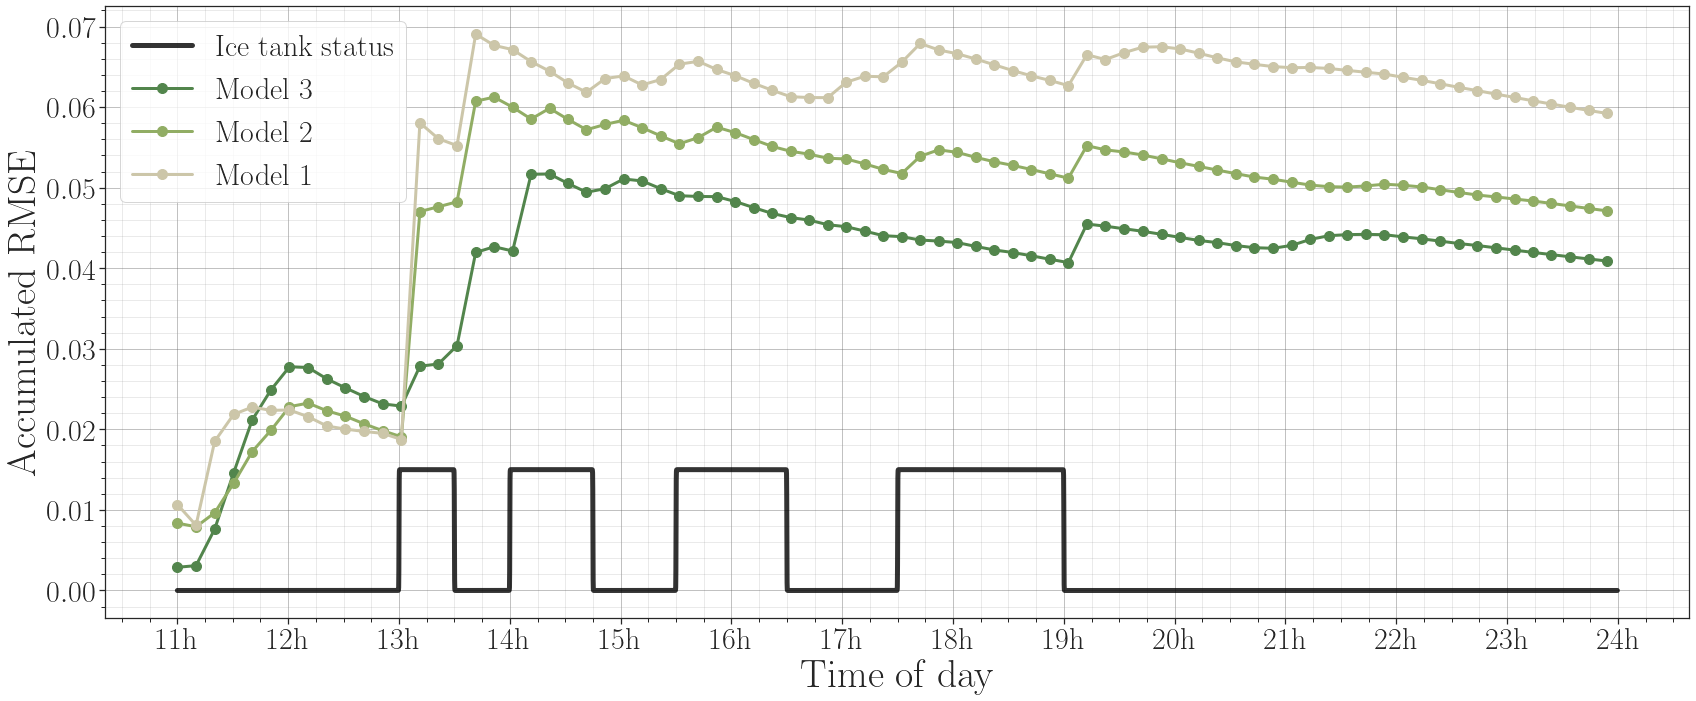

In [20]:
n = Z1[0][::100].shape[0]
RMS1 = np.sqrt(1/np.arange(1,n+1) * np.cumsum(np.power(Z1[0][::100] - data['A40_A_CompCap'][::100],2)))
RMS2 = np.sqrt(1/np.arange(1,n+1) * np.cumsum(np.power(Z2[0][::100] - data['A40_A_CompCap'][::100],2)))
RMS3 = np.sqrt(1/np.arange(1,n+1) * np.cumsum(np.power(Z3[0][::100] - data['A40_A_CompCap'][::100],2)))

fig = plt.figure(figsize=(25,10))    
ax = fig.add_subplot(111)
t_all = data['t']
t = t_all[::100]
ax.plot(T,smooth_regime(T,switches_data)*0.015,alpha=0.8,color='black',linewidth=5,label=r'$\textnormal{Ice tank status}$')
#ax.plot(t_all, data['A40_A_CompCap'], '-',linewidth=4,color='black',alpha = 0.2,label=r'$\textnormal{Observations}$')
ax.plot(t, RMS3,'o-',linewidth=3,markersize=10,color=col_mod3,label=r'$\textnormal{Model 3}$') #dodgerblue
ax.plot(t, RMS2,'o-',linewidth=3,markersize=10,color=col_mod2_line,label=r'$\textnormal{Model 2}$') #dodgerblue
ax.plot(t, RMS1,'o-',linewidth=3,markersize=10,color=col_mod1_line,label=r'$\textnormal{Model 1}$') #dodgerblue

n_days_skip_x = 1
setupAxis(ax)
ax.set_xticks(np.arange(0,14,1)*(60.) )
#ax.set_yticks(np.arange(5,11,1)*(0.1) )
#ax.set_yticks(np.arange(5,11,1)*(0.1), ) 
#ax.set_yticklabels(['$'+str(int(val)) + '$' for val in np.arange(50,110,10)]) 
ax.set_xticklabels(['$'+str(int(_t/60.)) + r' \textnormal{h}$' for _t in np.arange(11,25,1) * 60.])
ax.set_xlabel(r'$\textnormal{Time of day}$',size = 40)
ax.set_ylabel(r'$\textnormal{Accumulated RMSE}$',size = 40)
#ax.set_ylim(0.4,35)
ax.legend(prop={'size': 30},ncol=1,loc = 'upper left')
plt.subplots_adjust(hspace = 0.,bottom=0.1, top =0.95,left = 0.07, right = 0.95,)

fig.savefig(FIGS + '/modelling/rmse.pdf',format='pdf')